✅ Načteno 989 souborů (experiments=[11 18  2  4  7 12 20  8  9 19 22 15 16 10 17  6 13])
✅ Načteno 290 souborů (experiments=[ 1 21  5  3 14])
Epoch [1/50] Loss_D: 1.3250 Loss_G: 0.6662
Epoch [2/50] Loss_D: 1.3649 Loss_G: 0.7740
Epoch [3/50] Loss_D: 1.4123 Loss_G: 0.8159
Epoch [4/50] Loss_D: 1.3119 Loss_G: 0.8316
Epoch [5/50] Loss_D: 1.2840 Loss_G: 0.9249
Epoch [6/50] Loss_D: 1.3483 Loss_G: 0.8228
Epoch [7/50] Loss_D: 1.3882 Loss_G: 0.8353
Epoch [8/50] Loss_D: 1.2790 Loss_G: 0.9209
Epoch [9/50] Loss_D: 1.3227 Loss_G: 0.8247
Epoch [10/50] Loss_D: 1.3855 Loss_G: 0.7686
Epoch [11/50] Loss_D: 1.2989 Loss_G: 0.9342
Epoch [12/50] Loss_D: 1.3467 Loss_G: 0.9768
Epoch [13/50] Loss_D: 1.2300 Loss_G: 0.9522
Epoch [14/50] Loss_D: 1.3876 Loss_G: 0.9398
Epoch [15/50] Loss_D: 1.1848 Loss_G: 1.0951
Epoch [16/50] Loss_D: 1.2672 Loss_G: 1.3030
Epoch [17/50] Loss_D: 1.3521 Loss_G: 1.0931
Epoch [18/50] Loss_D: 1.1889 Loss_G: 1.4149
Epoch [19/50] Loss_D: 1.4333 Loss_G: 0.9169
Epoch [20/50] Loss_D: 1.1971 Lo

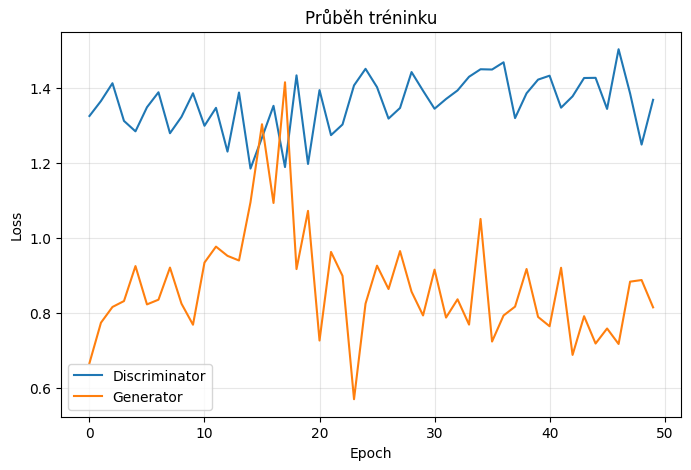

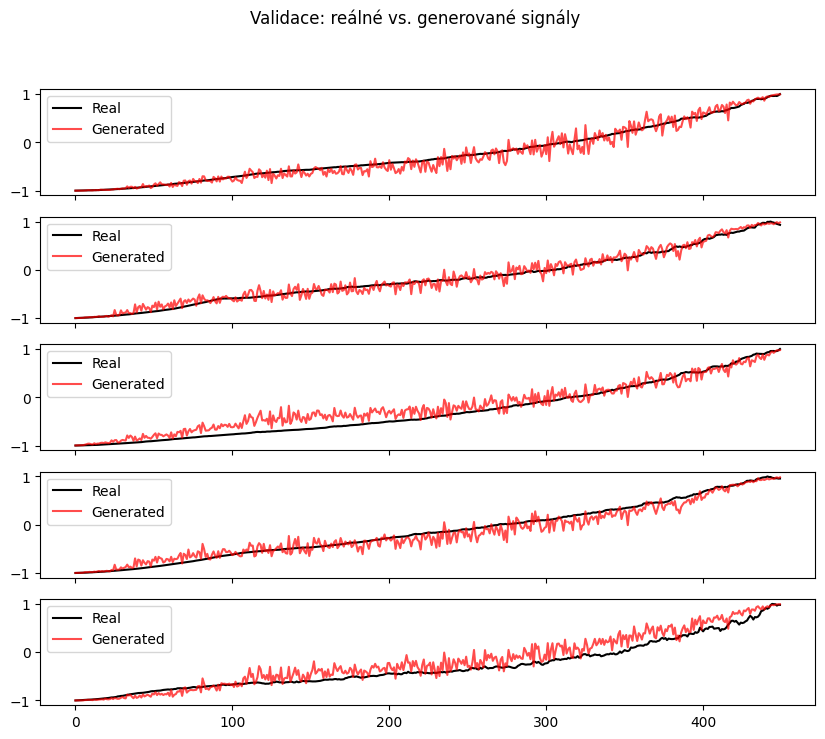

In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ====================================
# Dataset loader
# ====================================
class Signal1DDataset(Dataset):
    def __init__(self, root_dir, params_csv, allowed_experiments=None,
                 normalize_signals=True, normalize_conditions=True):
        self.root_dir = root_dir
        self.params_df = pd.read_csv(params_csv)

        if allowed_experiments is not None:
            self.params_df = self.params_df[self.params_df["experiment"].isin(allowed_experiments)]

        self.samples = []
        for _, row in self.params_df.iterrows():
            folder_id = str(int(row["experiment"]))
            folder_path = os.path.join(root_dir, folder_id)
            if not os.path.isdir(folder_path):
                continue
            for fname in os.listdir(folder_path):
                if fname.lower().endswith(".csv"):
                    fpath = os.path.join(folder_path, fname)
                    conditions = row.drop("experiment").values
                    self.samples.append((fpath, conditions))

        print(f"Načteno {len(self.samples)} souborů (experiments={allowed_experiments})")

        self.normalize_signals = normalize_signals
        self.normalize_conditions = normalize_conditions
        if normalize_conditions and len(self.samples) > 0:
            all_conditions = np.stack([s[1] for s in self.samples])
            self.cond_mean = all_conditions.mean(axis=0)
            self.cond_std = all_conditions.std(axis=0)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        signal_path, cond = self.samples[idx]
        df = pd.read_csv(signal_path)

        if "intensity" in df.columns:
            signal = df["intensity"].values.astype(np.float32)
        else:
            signal = df.iloc[:, -1].values.astype(np.float32)

        if self.normalize_signals:
            signal = (signal - signal.min()) / (signal.max() - signal.min() + 1e-8)
            signal = signal * 2.0 - 1.0

        cond = cond.astype(np.float32)
        if self.normalize_conditions:
            cond = (cond - self.cond_mean) / (self.cond_std + 1e-8)

        return torch.from_numpy(signal), torch.from_numpy(cond)


# ====================================
# Modely GANu
# ====================================
class Generator1D(nn.Module):
    def __init__(self, noise_dim=64, cond_dim=5, signal_len=450):
        super().__init__()
        input_dim = noise_dim + cond_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, signal_len),
            nn.Tanh()
        )
    def forward(self, noise, cond):
        x = torch.cat([noise, cond], dim=1)
        return self.net(x)


class Discriminator1D(nn.Module):
    def __init__(self, cond_dim=5, signal_len=450):
        super().__init__()
        input_dim = signal_len + cond_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, signal, cond):
        x = torch.cat([signal, cond], dim=1)
        return self.net(x)


# ====================================
# Trénink GANu
# ====================================
def train_gan(G, D, train_loader, noise_dim, num_epochs=50, lr=0.0002, device="cpu"):
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

    history = {"loss_D": [], "loss_G": []}

    for epoch in range(num_epochs):
        for signals, conds in train_loader:
            signals = signals.to(device).float()
            conds = conds.to(device).float()
            b_size = signals.size(0)

            # --- Discriminator ---
            D.zero_grad()
            labels_real = torch.full((b_size, 1), 1.0, device=device)
            output_real = D(signals, conds)
            loss_D_real = criterion(output_real, labels_real)
            loss_D_real.backward()

            noise = torch.randn(b_size, noise_dim, device=device)
            fake_signals = G(noise, conds)
            labels_fake = torch.full((b_size, 1), 0.0, device=device)
            output_fake = D(fake_signals.detach(), conds)
            loss_D_fake = criterion(output_fake, labels_fake)
            loss_D_fake.backward()

            loss_D = loss_D_real + loss_D_fake
            optimizer_D.step()

            # --- Generator ---
            G.zero_grad()
            labels_fake.fill_(1.0)  # chceme, aby fake vypadal jako real
            output = D(fake_signals, conds)
            loss_G = criterion(output, labels_fake)
            loss_G.backward()
            optimizer_G.step()

        history["loss_D"].append(loss_D.item())
        history["loss_G"].append(loss_G.item())
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")

    return history


# ====================================
# Validace GANu
# ====================================
def validate_gan(G, val_dataset, noise_dim=64, num_samples=5, device="cpu"):
    G.eval()
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 8), sharex=True)
    for i, idx in enumerate(indices):
        real_signal, cond = val_dataset[idx]
        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)
        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().flatten()

        axes[i].plot(real_signal.numpy(), label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].legend()
    plt.suptitle("Validace: reálné vs. generované signály")
    plt.show()


# ====================================
# Hlavní běh
# ====================================
if __name__ == "__main__":
    root_dir = "1D_spec"
    params_csv = "1D_spec/params.csv"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # rozdělení experiments na train/val
    params_df = pd.read_csv(params_csv)
    all_experiments = params_df["experiment"].unique()
    np.random.shuffle(all_experiments)
    split_ratio = 0.8
    split_idx = int(len(all_experiments) * split_ratio)
    train_exps = all_experiments[:split_idx]
    val_exps = all_experiments[split_idx:]

    train_dataset = Signal1DDataset(root_dir, params_csv, allowed_experiments=train_exps)
    val_dataset   = Signal1DDataset(root_dir, params_csv, allowed_experiments=val_exps)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    noise_dim = 64
    cond_dim = train_dataset[0][1].shape[0]
    signal_len = train_dataset[0][0].shape[0]

    G = Generator1D(noise_dim=noise_dim, cond_dim=cond_dim, signal_len=signal_len).to(device)
    D = Discriminator1D(cond_dim=cond_dim, signal_len=signal_len).to(device)

    # trénink
    history = train_gan(G, D, train_loader, noise_dim, num_epochs=50, device=device)

    # graf lossů
    plt.figure(figsize=(8,5))
    plt.plot(history["loss_D"], label="Discriminator")
    plt.plot(history["loss_G"], label="Generator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Průběh tréninku")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # validace
    validate_gan(G, val_dataset, noise_dim=noise_dim, num_samples=5, device=device)


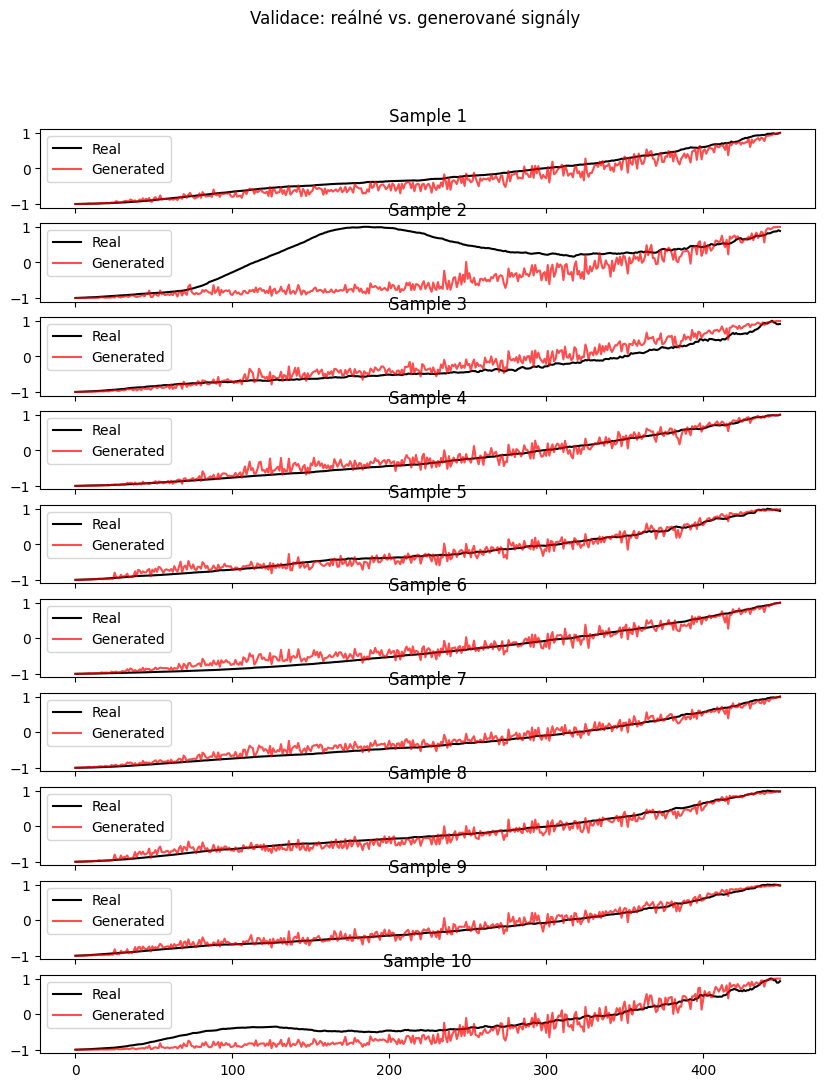

📊 Výsledky validace:
 sample_id      MSE     Corr        R2   CosSim  DTW_dist
       161 0.023372 0.977705  0.921650 0.967690       NaN
       175 0.752143 0.425325 -1.064555 0.131526       NaN
        91 0.037472 0.973869  0.843247 0.947287       NaN
       123 0.016765 0.977959  0.950355 0.978593       NaN
       249 0.012861 0.978544  0.956880 0.981191       NaN
        36 0.022148 0.975429  0.934463 0.978719       NaN
       159 0.014695 0.982754  0.951201 0.983015       NaN
       208 0.012336 0.980335  0.958559 0.981320       NaN
       247 0.010101 0.985610  0.965783 0.985386       NaN
       104 0.069213 0.945471  0.676216 0.955305       NaN

📈 Shrnutí (průměr přes všechny vzorky):
MSE       : 0.097111
Corr      : 0.920300
R2        : 0.709380
CosSim    : 0.889003
DTW_dist  : NaN


In [14]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine, euclidean
from fastdtw import fastdtw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

def validate_gan(G, val_dataset, noise_dim=64, num_samples=10, device="cpu"):
    """
    Validace GANu:
    - vykreslí real vs. generated signály
    - spočítá metriky: MSE, Corr, R2, Cosine similarity, DTW distance
    - vytiskne tabulku výsledků a průměrné hodnoty
    """
    G.eval()
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    results = []
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 12), sharex=True)

    for i, idx in enumerate(indices):
        real_signal, cond = val_dataset[idx]
        cond = cond.unsqueeze(0).to(device).float()
        noise = torch.randn(1, noise_dim, device=device)

        with torch.no_grad():
            fake_signal = G(noise, cond).cpu().numpy().ravel()

        real_np = np.array(real_signal.numpy()).ravel()  # vždy 1D

        # --- metriky ---
        mse = mean_squared_error(real_np, fake_signal)

        try:
            corr, _ = pearsonr(real_np, fake_signal)
        except Exception:
            corr = np.nan

        try:
            r2 = r2_score(real_np, fake_signal)
        except Exception:
            r2 = np.nan

        try:
            cos_sim = 1 - cosine(real_np, fake_signal)
        except Exception:
            cos_sim = np.nan

        try:
            dtw_dist, _ = fastdtw(real_np, fake_signal, dist=euclidean)
        except Exception:
            dtw_dist = np.nan

        results.append({
            "sample_id": idx,
            "MSE": mse,
            "Corr": corr,
            "R2": r2,
            "CosSim": cos_sim,
            "DTW_dist": dtw_dist
        })

        # --- graf ---
        axes[i].plot(real_np, label="Real", color="black")
        axes[i].plot(fake_signal, label="Generated", color="red", alpha=0.7)
        axes[i].legend()
        axes[i].set_title(f"Sample {i+1}")

    plt.suptitle("Validace: reálné vs. generované signály")
    plt.show()

    # --- tabulka výsledků ---
    df = pd.DataFrame(results)
    print("Výsledky validace:")
    print(df.to_string(index=False))

    # --- agregované statistiky ---
    print("\n Shrnutí (průměr přes všechny vzorky):")
    for col in ["MSE", "Corr", "R2", "CosSim", "DTW_dist"]:
        vals = df[col].dropna()
        if len(vals) > 0:
            print(f"{col:10s}: {vals.mean():.6f}")
        else:
            print(f"{col:10s}: NaN")


validate_gan(G, val_dataset, noise_dim=noise_dim, num_samples=10, device=device)


